# Board Game Collection Analysis: Judd Jacobs vs. Adam Bartoszek

This analysis and comparison aims to examine the board game collections of **Judd Jacobs** and **Adam Bartoszek** in relation to an assumed complete dataset sourced from **Board Games Geek (BGG)**. 

**Board Games Geek** is a comprehensive platform that catalogs board games, providing detailed information about a wide range of games, such as:

- **Year of publication**
- **Suggested age range**
- **Type of gameplay**
- And many other attributes...

The goal of this analysis is to provide insights into the two collections, exploring how they align with the broader dataset and identifying potential trends or notable differences.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

ab_collection_path = "./Collections/AB_Collection.csv"
jj_collection_path = "./Collections//JJ_Collection.csv"
bgg_collection_path = "./Collections//bgg_dataset.csv"
age_mapping_path = "./Collections//AgeRangeMapping.xlsx"
#mechanics_path = "./Database_Tables_BGG/mechanics.csv"
#subcat_path = "./Database_Tables_BGG/subcategories.csv"
#themes_path = "./Database_Tables_BGG/themes.csv"

jj_df = pd.read_csv(jj_collection_path, sep=',')
ab_df = pd.read_csv(ab_collection_path, sep=',')
bgg_df = pd.read_csv(bgg_collection_path, sep=';')
age_df = pd.read_excel(age_mapping_path, engine='openpyxl')
#mech_df = pd.read_csv(mechanics_path, sep=',')
#sub_df = pd.read_csv(subcat_path, sep=',')
#theme_df = pd.read_csv(themes_path, sep=',')

def filter_dataframe(df):
    # Remove expansions from the list since they are add-ons to an existing game, not a new game itself
    filtered_df = df[df['itemtype'] != 'expansion']
    return filtered_df

def apply_suffix(df, suffix):
    # add suffix to all columns in DF to support easier separation and analysis
    return df.add_suffix(suffix)

def choose_age(row):
    # Check the values in my preferred order--chosen b/c I preferred the representation in the person collections
    # I started with Adam's b/c his was largest of those two.
    for col in ['bggrecagerange_ab', 'bggrecagerange_jj', 'Min Age']:
        if pd.notnull(row[col]):
            return row[col]
    return None  # Return None if all are NaN/NULL

jj_df_filtered = filter_dataframe(jj_df)
ab_df_filtered = filter_dataframe(ab_df)

jj_df_suffixed = apply_suffix(jj_df_filtered, '_jj')
ab_df_suffixed = apply_suffix(ab_df_filtered, '_ab')

# Merge AB & JJ as outer first, added a new column to collect objectid as one combined column, similar for ageranges
ab_jj_outer = pd.merge(jj_df_suffixed, ab_df_suffixed, left_on='objectid_jj', right_on='objectid_ab', how='outer')
ab_jj_outer['objectid_comb'] = ab_jj_outer['objectid_ab'].combine_first(ab_jj_outer['objectid_jj'])
ab_jj_outer['bggrecagerange_comb'] = ab_jj_outer['bggrecagerange_ab'].combine_first(ab_jj_outer['bggrecagerange_jj'])

# Merge joined AB&JJ data to largest BGG dataset
result = pd.merge(bgg_df, ab_jj_outer, left_on='ID', right_on='objectid_comb', how='left')

# create new column to capture and combine all age ranges from all 3 datasets based on most preferred to least as outlined in above function
result['age_comb'] = result.apply(choose_age, axis=1)

# merge age range mapping for cleaner representation and aggregation
result = pd.merge(result, age_df, left_on='age_comb', right_on='bggrecagerange', how='left')


#print(jj_df_suffixed.columns)
#print(ab_df_suffixed.columns)
#print(ab_jj_outer.columns)
#print(list(result.columns))
row_count = result.count().max()
print(f"Number of rows: {row_count}")

Number of rows: 20350


20327
1757
298
Out of the total 20327 games listed on Board Games Geek, Adam has 1757 or 8.64% and Judd has 298 or 1.47%


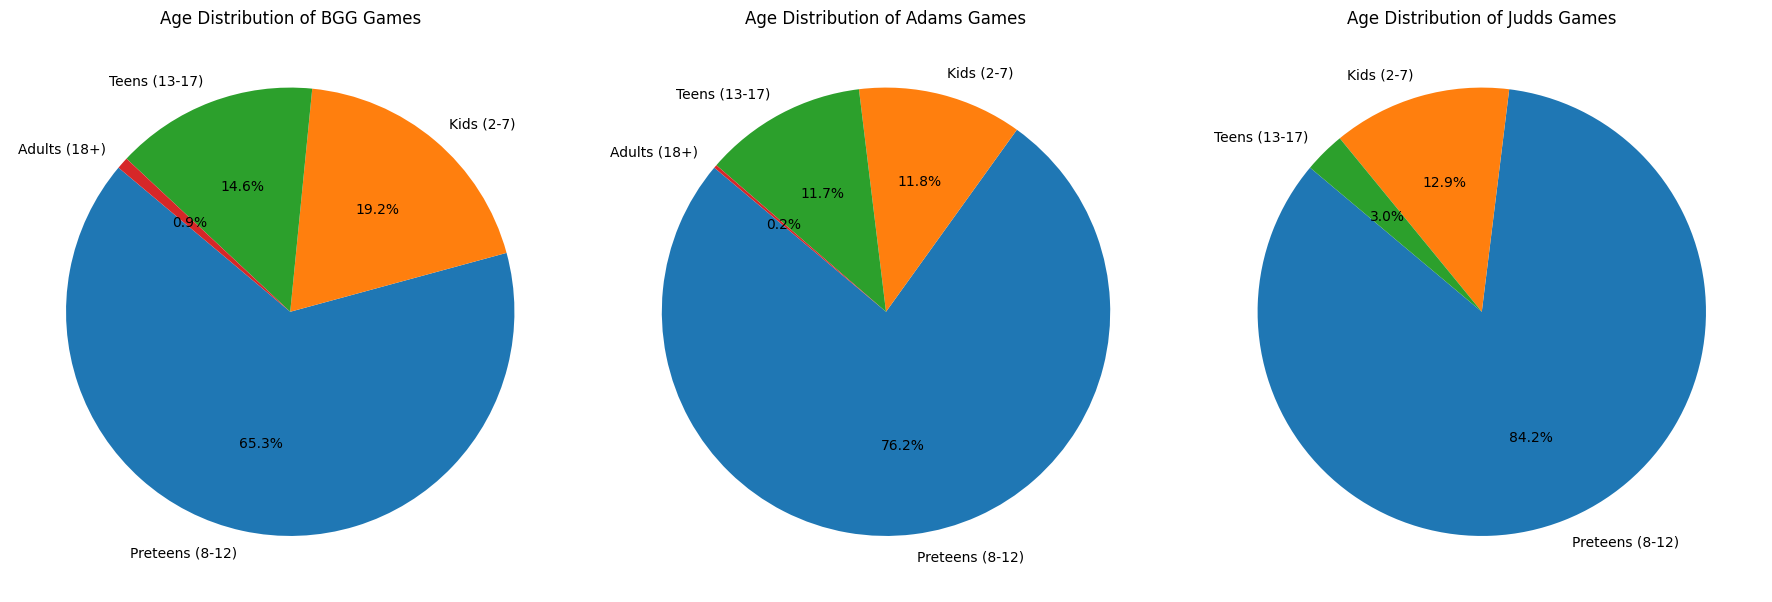

In [2]:
#Analysis
# Step 1: Count distinct values in 'ID' column
distinct_id_count = result['ID'].nunique()

# Step 2: Count distinct, non-NaN values in 'objectid_ab' column
dist_objectid_ab = result[result['itemtype_ab'] != 'expansion']['objectid_ab'].dropna().loc[result['objectid_ab'] != ''].nunique()
dist_objectid_jj = result[result['itemtype_jj'] != 'expansion']['objectid_jj'].dropna().loc[result['objectid_jj'] != ''].nunique()
print(distinct_id_count)
print(dist_objectid_ab)
print(dist_objectid_jj)

# Step 3: Calculate the percentage
ab_totalperc = round((dist_objectid_ab / distinct_id_count) * 100, 2)
jj_totalperc = round((dist_objectid_jj / distinct_id_count) * 100, 2)

bgg_age_counts = result['AggregateMapping'].value_counts()
ab_age_counts = result[result['objectid_ab'].notna()]['AggregateMapping'].value_counts()
jj_age_counts = result[result['objectid_jj'].notna()]['AggregateMapping'].value_counts()

# Print the result
print(f"Out of the total {distinct_id_count} games listed on Board Games Geek, Adam has {dist_objectid_ab} or {ab_totalperc}% and Judd has {dist_objectid_jj} or {jj_totalperc}%") 

# Output the result dataframe to an Excel file
#result.to_excel('result.xlsx', index=False)
#ab_jj_outer.to_excel('ab_jj_outer.xlsx', index=False)

# Create a figure with 1 row and 3 columns (for 3 pie charts)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjust size as needed

# Pie chart for BGG
axes[0].pie(bgg_age_counts, labels=bgg_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Age Distribution of BGG Games')

# Pie chart for AB
axes[1].pie(ab_age_counts, labels=ab_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Age Distribution of Adam''s Games')

# Pie chart for JJ
axes[2].pie(jj_age_counts, labels=jj_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Age Distribution of Judd''s Games')

# Display the pie charts
plt.tight_layout()  # Automatically adjusts the layout to prevent overlap
plt.show()


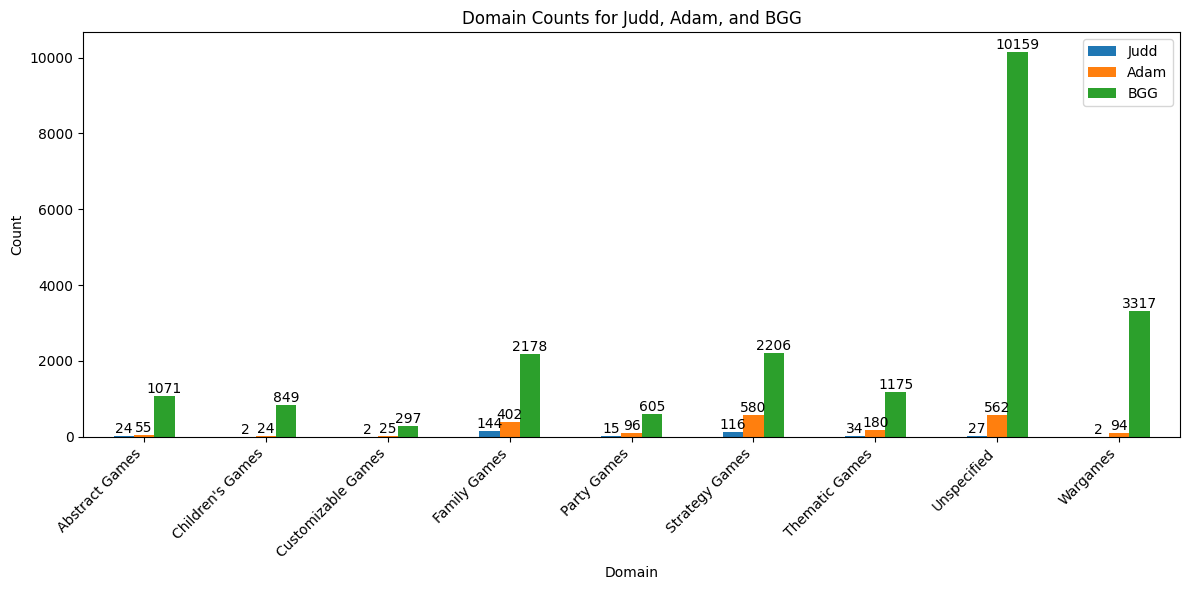

In [3]:
# Further analysis by 'Domains' (type of game)
# Step 1: Split 'Domains' into separate rows and handle spaces and empty values
result['Domains'] = result['Domains'].fillna('').astype(str)
result['Domains'] = result['Domains'].str.split(',').apply(lambda x: [item.strip() if item.strip() != '' else 'Unspecified' for item in x])

result_split = result.explode('Domains')

# Step 2: Initialize columns for JJ, AB, and BGG counts
result_split['Judd'] = 0
result_split['Adam'] = 0
result_split['BGG'] = 0

# Step 3: Update counts based on the conditions
# Update JJ count for rows where own_jj == 1
result_split.loc[result_split['own_jj'] == 1, 'Judd'] = 1

# Update AB count for rows where own_ab == 1
result_split.loc[result_split['own_ab'] == 1, 'Adam'] = 1

# Update BGG count for all rows (since it's simply a presence count)
result_split['BGG'] = 1

#result.to_excel('result_split.xlsx', index=False)
#print(result_split.head)

# Step 4: Group by 'Domains' and sum the counts to avoid duplication
aggregated_data = result_split.groupby('Domains')[['Judd', 'Adam', 'BGG']].sum()

# Step 5: Plot the bar graph (value labels)
ax = aggregated_data.plot(kind='bar', figsize=(12, 6))

# Customize the plot
plt.title('Domain Counts for Judd, Adam, and BGG')
plt.ylabel('Count')
plt.xlabel('Domain')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent overlap

ax.bar_label(ax.containers[0])  # This will add labels for the first container (Judd column)
ax.bar_label(ax.containers[1])  # This will add labels for the second container (Adam column)
ax.bar_label(ax.containers[2])  # This will add labels for the third container (BGG column)

# Show the plot
plt.show()
